In [1]:
import csv
# import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers import Convolution2D, ELU
from keras.layers.convolutional import Cropping2D
from keras import regularizers
import matplotlib.image as mpimg
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pickle
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from keras import optimizers
%matplotlib inline

Using TensorFlow backend.


In [2]:
def modify_brightness(img):
    """
    Modify the brightness of a RGB img (imported by matplotlib).
    """
    # get a random number in range [0.5, 1.5]
    change = random.random() + 0.5
    hsv = rgb_to_hsv(img)
    hsv *= change
    hsv[:,:,2][hsv[:,:,2] > 255] = 255
    rgb = hsv_to_rgb(hsv)
    return rgb

In [3]:
def get_data_center(path):
    """
    Get data from a directory. Each directory has a 'driving_log.csv' file, and
    an 'IMG' folder.
    Only center images.
    Input: path should have the slash in the end, e.g './data/'
    """
    lines = []
    with open(path + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    # read the csv file 
    images = []
    # side_images = []
    steering_angles = []
    for line in lines:
        img_center_path = line[0].split('/')[-1]
        current_path = path + 'IMG/'
        img_center = mpimg.imread(current_path + img_center_path)
        images.append(img_center)
        steering_center = float(line[3])
        steering_angles.append(steering_center)
    # convert to numpy array
    X = np.array(images)
    y = np.array(steering_angles)
    return X, y

In [4]:
def get_data_sides(path, correction=0.3, only_Y=False):
    """
    Get data from a directory. Each directory has a 'driving_log.csv' file, and
    an 'IMG' folder.
    Only side images.
    Input: path should have the slash in the end, e.g './data/'
    """
    lines = []
    with open(path + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    # read the csv file 
    images = []
    steering_angles = []
    for line in lines:
        if not only_Y:
            img_left_path = line[1].split('/')[-1]
            img_right_path = line[2].split('/')[-1]
            current_path = path + 'IMG/'
            img_left = mpimg.imread(current_path + img_left_path)
            img_right = mpimg.imread(current_path + img_right_path)
            images.extend([img_left, img_right])
        # get steering data
        steering_center = float(line[3])
        # steering_angles.append(steering_center)
        # create adjusted steering measurements for the side camera images
        steering_left = steering_center + correction
        steering_right = steering_center - correction
        steering_angles.extend([steering_left, steering_right])
    # convert to numpy array
    y = np.array(steering_angles)
    if not only_Y:
        X = np.array(images)
        return X, y
    else:
        return y

#### Example of image augmentation

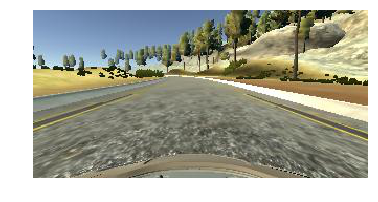

In [8]:
img_center = mpimg.imread('./figs/center_example.jpg')
plt.axis('off')
plt.imshow(img_center)

(-0.5, 319.5, 159.5, -0.5)

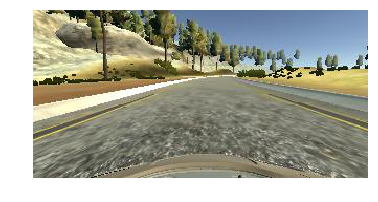

In [17]:
plt.imshow(np.fliplr(img_center))
plt.axis('off')

(-0.5, 319.5, 159.5, -0.5)

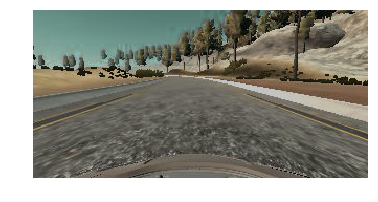

In [22]:
plt.imshow(modify_brightness(img_center)/255.)
plt.axis('off')

### Generators

In [58]:
def get_samples(path):
    """
    Get the samples description from csv file.
    """
    samples = []
    with open(path + '/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples.append((path, line))
            # samples.append(line)
    return samples

In [59]:
train_samples = []
train_samples.extend(get_samples('./track1/'))
train_samples.extend(get_samples('./track1-recover/'))
train_samples.extend(get_samples('./track2/'))
train_samples.extend(get_samples('./track2-recover/'))

In [60]:
valid_samples = []
valid_samples.extend(get_samples('./valid1/'))
valid_samples.extend(get_samples('./valid2/'))
valid_samples.extend(get_samples('./valid3/'))
valid_samples.extend(get_samples('./valid4/'))

In [61]:
print(train_samples[100])
print(valid_samples[100])

('./track1/', ['/Users/trimcao/Documents/learning/self-driving-udacity/CarND-Behavioral-Cloning-P3/track1/IMG/center_2017_06_23_10_29_18_735.jpg', '/Users/trimcao/Documents/learning/self-driving-udacity/CarND-Behavioral-Cloning-P3/track1/IMG/left_2017_06_23_10_29_18_735.jpg', '/Users/trimcao/Documents/learning/self-driving-udacity/CarND-Behavioral-Cloning-P3/track1/IMG/right_2017_06_23_10_29_18_735.jpg', '0', '0', '0', '22.00984'])
('./valid1/', ['/Users/trimcao/Documents/learning/self-driving-udacity/CarND-Behavioral-Cloning-P3/valid1/IMG/center_2017_06_23_14_47_45_642.jpg', '/Users/trimcao/Documents/learning/self-driving-udacity/CarND-Behavioral-Cloning-P3/valid1/IMG/left_2017_06_23_14_47_45_642.jpg', '/Users/trimcao/Documents/learning/self-driving-udacity/CarND-Behavioral-Cloning-P3/valid1/IMG/right_2017_06_23_14_47_45_642.jpg', '0', '0.5642702', '0', '28.76771'])


In [67]:
def generator(samples, batch_size=128, mode='valid', steer_correct=0.25):
    """
    Generator for model training.
    mode can be 'train' or 'valid'. 
    """
    num_samples = len(samples)
    while True: 
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            # load the images
            images = []
            angles = []
            if mode == 'train':
                for batch_sample in batch_samples:
                    # obtain center, left, and right images
                    path = batch_sample[0] + 'IMG/'
                    info = batch_sample[1]
                    center_name = path + info[0].split('/')[-1]
                    center_image = mpimg.imread(center_name)
                    center_angle = float(info[3])
                    # left image
                    left_name = path + info[1].split('/')[-1]
                    left_image = mpimg.imread(left_name)
                    left_angle = center_angle + steer_correct
                    # right image
                    right_name = path + info[2].split('/')[-1]
                    right_image = mpimg.imread(right_name)
                    right_angle = center_angle - steer_correct
                    # augmentation: change brightness 
                    mod_brightness = modify_brightness(center_image)
                    # augmentation: flip image
                    flip = np.fliplr(center_image)
                    flip_angle = -1. * center_angle
                    images.extend([center_image, left_image, right_image, mod_brightness, flip])
                    angles.extend([center_angle, left_angle, right_angle, center_angle, flip_angle])
            else:
                for batch_sample in batch_samples:
                    path = batch_sample[0] + 'IMG/'
                    info = batch_sample[1]
                    name = path + info[0].split('/')[-1]
                    # name = batch_sample[0]
                    center_image = mpimg.imread(name)
                    center_angle = float(info[3])
                    images.append(center_image)
                    angles.append(center_angle)
            # convert to numpy arrays
            X_train = np.array(images)
            y_train = np.array(angles)
            #print(X_train.shape)
            #print(y_train.shape)
            yield shuffle(X_train, y_train)

In [68]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=128, mode='train')
validation_generator = generator(valid_samples, batch_size=128, mode='valid')
# ch, row, col = 3, 80, 320  # Trimmed image format
# model = Sequential()
# # Preprocess incoming data, centered around zero with small standard deviation 
# model.add(Lambda(lambda x: x/127.5 - 1.,
#         input_shape=(ch, row, col),
#         output_shape=(ch, row, col)))

### Train the network

#### Using NVIDIA architecture

In [69]:
input_shape = (160, 320, 3)
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=input_shape))
model.add(Cropping2D(cropping=((50,20),(0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation='elu'))
model.add(Dropout(0.2))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='elu'))
model.add(Dropout(0.2))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='elu'))
model.add(Dropout(0.2))
model.add(Convolution2D(64,3,3, activation='elu'))
model.add(Dropout(0.2))
model.add(Convolution2D(64,3,3, activation='elu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(1))

#### Compile and train the model

In [72]:
model.compile(loss='mse', optimizer=optimizers.Adam(lr=1e-4))
check_point = ModelCheckpoint('./checkpoints/model-e{epoch:03d}.h5', monitor='val_loss',
                              verbose=0, save_best_only=False, save_weights_only=False, mode='auto')
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')

In [73]:
model.fit_generator(train_generator, samples_per_epoch=5*len(train_samples),
                    validation_data=validation_generator,
                    nb_val_samples=len(valid_samples),
                    nb_epoch=10, callbacks=[check_point, early_stop])

Epoch 1/10
62205/62205 [==============================] - 239s - loss: 0.1795 - val_loss: 0.1740
Epoch 2/10
62205/62205 [==============================] - 229s - loss: 0.1770 - val_loss: 0.1719
Epoch 3/10
62205/62205 [==============================] - 232s - loss: 0.1639 - val_loss: 0.1466
Epoch 4/10
62205/62205 [==============================] - 230s - loss: 0.1726 - val_loss: 0.1735
Epoch 5/10
62205/62205 [==============================] - 231s - loss: 0.1775 - val_loss: 0.1517
Epoch 6/10
62205/62205 [==============================] - 230s - loss: 0.1587 - val_loss: 0.1719
Epoch 7/10
62205/62205 [==============================] - 229s - loss: 0.1524 - val_loss: 0.1414
Epoch 8/10
62205/62205 [==============================] - 228s - loss: 0.1683 - val_loss: 0.1466
Epoch 9/10
62205/62205 [==============================] - 231s - loss: 0.1878 - val_loss: 0.1499
Epoch 10/10
62205/62205 [==============================] - 231s - loss: nan - val_loss: nan


dict_keys(['val_loss', 'loss'])


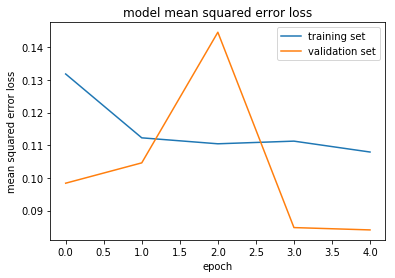

In [35]:
# print the output of model
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
model.save('model.h5')

#### Comma.AI architecture

In [ ]:
# # Comma.AI model
# input_shape = (160, 320, 3)
# model = Sequential()
# model.add(Lambda(lambda x: x/127.5 - 1.,
#         input_shape=input_shape))
# model.add(Cropping2D(cropping=((50,20),(0,0))))
# model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
# model.add(ELU())
# model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
# model.add(ELU())
# model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
# model.add(Flatten())
# model.add(Dropout(.2))
# model.add(ELU())
# model.add(Dense(512))
# model.add(Dropout(.5))
# model.add(ELU())
# model.add(Dense(1))